#  Global Optimisation with Gaussian Processes [Bayesian Optimisation]

Adapted from 
#### Gaussian Process Summer School 2018

_Author_ Sanket Kamthe

The goal of this tutorial session is to illustrate how to use Gaussian processes for Global optimization. 

We will focus on two aspects of Bayesian Optimization (BO): 
1. Choice of the model 
2. Acquisition function.

The technical material associated to the methods used in this lab can be found on the lecture slides. We have tried to use the same notation as that used in lecture slides

In [1]:
import GPy
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
import matplotlib.style as style
%matplotlib inline
style.use('ggplot')

# If colour blind uncomment line below
style.use('seaborn-colorblind')


In [2]:
import numpy as np

Before starting with the lab, remember that (BO) is an heuristic for global optimization of black-box functions. Let $f: {\mathcal X} \to R$ be a 'well behaved' continuous function defined on a compact subset ${\mathcal X} \subseteq R^d$. Our goal is to solve the global optimization problem of finding
$$ x_{M} = \arg \min_{x \in {\mathcal X}} f(x). $$

We assume that $f$ is a *black-box* from which only perturbed evaluations of the type $y_i = f(x_i) + \epsilon_i$, with $\epsilon_i \sim\mathcal{N}(0,\sigma^2)$, are  available. The goal is to find $x_M$ by minimizing the number of evaluations of $f$. To do this, we need to determine two crucial bits:

1. A **Gaussian process** that will capture the our beliefs on $f$. 

2. An **acquisition function** that based on the model will be useful to determine where to collect new evaluations of f. 

Remember that every time a new data point is collected the model is updated and the acquisition function optimized again. 

Let's create some benchmark functions to work with. We only work with 1 D functions as they are easy to plot and visualise. 

In [3]:
class Objective:
    def __init__(self, func=None, limits=[0.0, 1.0], true_min=0.0, noise_std=0.0):
        self.noise_std = noise_std
        self.limits = limits
        self.f_true = func
        self.true_min = true_min
    
    def __call__(self, x):
        return self.f_true(x) + np.random.randn(*x.shape) * self.noise_std
    
    @classmethod
    def forrester(cls):
        
        '''
        Details at 
        https://www.sfu.ca/~ssurjano/forretal08.html
        
        '''
        def forrester(x):
            return (6.0 * x - 2 ) ** 2 * np.sin(12 * x - 4)
        
        return cls(func=forrester, limits = [0.0, 1.0], true_min=0.78 )
    
    @classmethod
    def rastrigrin(cls):
        """
        https://www.sfu.ca/~ssurjano/rastr.html
        
        """
        def rastgrin(x):
            return (6.0 * x - 2 ) ** 2 * np.sin(12 * x - 4)
        
        return cls(func=rastrigrin, limits = [-5.12, 5.12], true_min=0.0)
    
    @classmethod
    def humps(cls):
        '''
        Custom function that shows importance of exploration
        '''
        def humps(x):
            return - (np.exp(-(x - 2) ** 2) + np.exp(-(x - 6) ** 2 / 10) + 1/ (x ** 2 + 1))
        
        return cls(func=humps, limits = [-2, 10], true_min=2.0, noise_std=0.00 )
        

### Running example

We start with a one-dimensional example. Consider here the Forrester function 

$$f(x) =(6x-2)^2 \sin(12x-4),$$ defined on the interval $[0, 1]$. 

The minimum of this function is located at $x_{min}=0.78$. We assume that the evaluations of $f$ to are perturbed by zero-mean Gaussian noise with standard deviation 0.25. The Forrester function is part of the benchmark of functions of GPyOpt. To create the true function, the perturbed version and the boundaries of the problem you need to run the following cell. 

In [4]:
obj = Objective.forrester()

To plot the true $f$:

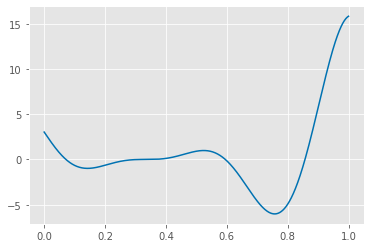

In [5]:
x = np.linspace(0.0, 1.0, num=1000)
plt.plot(x, obj(x))

### Define a GP prior

We use GPy package as it has GP training and prediction available for us.

We define a simple GP with Square Exponential Kernel 

GPy models need initial data to define a model so first let's collect few samples from our objective

In [6]:
def init_points(objective, n=3, seed=1234):
    np.random.seed(seed=seed)
    a, b = objective.limits
    scale = b-a
    x_init = scale * np.random.rand(n,1) - a

    y_init = objective(x_init)
    
    return x_init, y_init
        

### Create Forrester Objective

Note in addition to the objective function the class below also has limits or bounds over which function is defined

In [7]:
obj = Objective.forrester()
obj.limits

[0.0, 1.0]

In [8]:
x_0, y_0 = init_points(obj, 5)
y_0

array([[-0.71780177],
       [-0.9549288 ],
       [ 0.37265649],
       [-5.56914488],
       [-5.72879715]])

### Create a GP model 

In [9]:
kernel = GPy.kern.RBF(1)
gp_model = GPy.models.GPRegression(x_0, y_0, kernel)

{'dataplot': [<matplotlib.collections.PathCollection at 0x205c416b730>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x205c416bc40>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x205c416bee0>]}

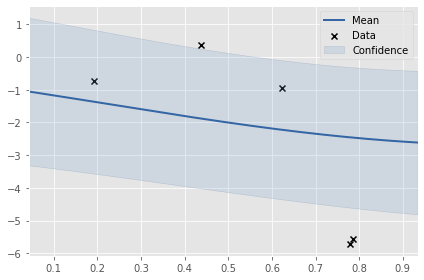

In [10]:
gp_model.plot()


### Now train the model and plot 


Name : GP regression
Objective : 9.435684067796991
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |       7.889126365921887  |      +ve      |        
  rbf.lengthscale          |      0.0842944003089231  |      +ve      |        
  Gaussian_noise.variance  |  4.4041784796034515e-09  |      +ve      |        


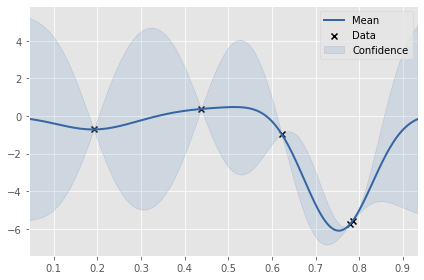

In [11]:
gp_model.optimize()
gp_model.plot()
print(gp_model)

## Acquisition Functions

Once we have a GP model we need a method to find the best point to evaluate next. Aquisition functions are used to pick the evaluation points. 

First we create a Aqusition base class 

refer lecture notes [slide 17] for the details. 


For 2 Acquisition functions we need the gamma function: 
            $$ \gamma(x) = \frac{f(x_{\text{best}}) - \mu(x) - \xi }{ \sigma(x)}$$
            
           
And a mechanism to find the argmax of the acquisition functions [Simplest way is to just evaluate function at a very fine grid and pick the best candidate]

In [12]:
class AquisitionBase:
    
    def __init__(self, Xi=0.0):
        """
        Xi is scalar slack variable, Xi=0.0 pure exploitation 
        larger values promote explorations [see lecture slides]
        """
        self.Xi = Xi 
        
    
    def __call__(model: GPy.Model, x: np.ndarray) -> np.ndarray:
        """
        
        :param model: GPy regression model [used to get \mu(x), var(x) = model.predict(x)]
        :param x: input at whih we evaluate acquisition function 
        :return: shape (N, ) or (N, 1)
        """
        raise NotImplementedError
    def gamma(self, y_best, mean_x, sigma_x):
        """
        :param y_best: float scalar best value so far 
        :param mean_x: numpy array of N x D where D is dimension [1 or None in this tutorial]
        :param sigma_x:numpy array of N x 1  
        :return: shape (N, ) or (N, 1)
        """
        
        gamma_x =  (- mean_x + y_best)/sigma_x # **Edited** (N,1)        
        return gamma_x

    def maximise(self, model, lims):
        a, b = lims
        x = np.linspace(a, b, num=10000)
        y = self.__call__(model, x.reshape(-1, 1))
        index = np.argmax(y)
        print()
        return x[index]

### Probability of Improvement
Complete the following cell with 
        $$ \alpha_{\text{PI}} = \mathbf(\Phi) (\gamma(x)) $$
         
where $ \mathbf(\Phi) $ is CDF of standard Normal distribution
##### Hint: You can use  'norm' from scipy.stats instead of implementing CDF by yourself

In [13]:
from scipy.stats import norm
class ProbabilityImprovement(AquisitionBase):
    
    def __call__(self, model, x):
        
        assert isinstance(model, GPy.Model)
        
        mean_x, cov_x = model.predict(x.reshape((len(x), 1)), full_cov=True) # ***Edited***
        sigma_x = np.sqrt(np.diag(cov_x))
        y_best = np.min(model.Y)
        
        gamma_x = self.gamma(y_best, mean_x.reshape(len(x)), sigma_x) 
        PI_x = norm.cdf(gamma_x) # ***Edited***
        return PI_x

In [14]:
PI = ProbabilityImprovement(AquisitionBase.gamma)
AF_PI = PI(gp_model,x)

(0.05, 0.94)

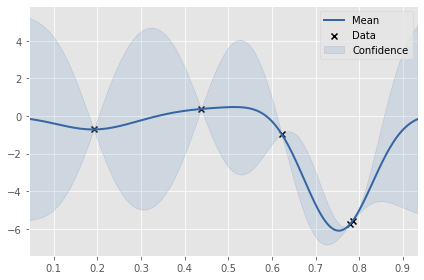

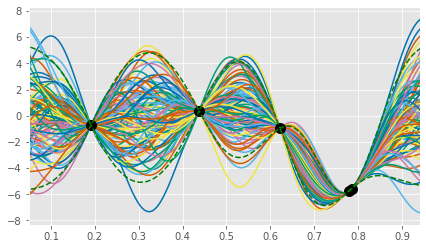

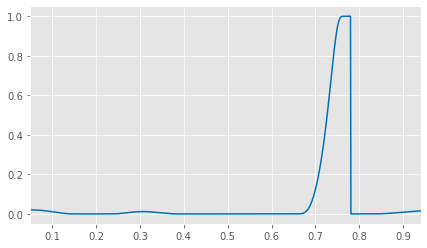

In [15]:
gp_model.plot()

posteriorTestY = gp_model.posterior_samples_f(x.reshape((1000, 1)), full_cov=True, size=100)
mean_x, std_x = gp_model.predict(x.reshape((1000, 1)))
plt.figure(figsize=(7,4))
plt.plot(x.reshape((1000, 1)), posteriorTestY[:,0,:])
plt.plot(x_0, y_0, 'ok', markersize=10)
plt.plot(x, mean_x - 2 * std_x ** 0.5, '--g')
plt.plot(x, mean_x + 2 * std_x ** 0.5, '--g')
plt.xlim([0.05,0.94])

plt.figure(figsize=(7,4))
plt.plot(np.linspace(0,1,1000),AF_PI)
plt.xlim([0.05,0.94])



### Algorithm  Basic pseudo-code for Bayesian optimization
1. Place a Gaussian process prior on $f$
2. Observe $f$ at $n_0$ points according to an initial space-filling experimental design.  Set $n=n_0 $.
3. __while__ $n≤N$ __do__ 
   1. Update the posterior probability distribution on $f$ using all available data
   - Let $x_n$ be a maximizer of the acquisition function over $x$, where the acquisition function is computed usingthe current posterior distribution.
   - Observe $y_n=f(x_n)$.
   - Increment $n$
   
4. __end__ __while__
5. Return a solution:  either the point evaluated with the largest $f(x)$, or the point with the largest posteriormean

Now complete the optimise class of the class below:

the initialisation of class covers the steps 1-3A. Implement steps 3B and 3C

#### Hint: these are simple one liners 

In [16]:
class BayesianOptmisation:
    
    def __init__(self, objective, aquisition_function, init_steps=2, kernel=GPy.kern.RBF(1),  seed=1234 ):
        
        self.objective = objective 
        x_init, y_init = self.init_points(n=init_steps, seed=seed)
        self.aquisition = aquisition_function
        self.model = GPy.models.GPRegression(x_init, y_init, kernel)
        self.model.optimize()
        # GP model fit may be poor uncomment line below if you find that repeated experimetns start with poor GP fit
#         self.model.optimize_restarts(20)
    
    def optimise(self, n_iter=10, plot=False, verbose=True):
        
        
        for i in range(n_iter):
            
            # Maximise your aquisition function to get next best x
            x_n = x[np.argmax(PI(self.model,x))]  # Edit This line ***Edited***
            
            # Evaluate objective at best X calculated above
            y_n = obj(x_n) # Edit This line ***Edited***
            
            # Update your model 
            self.update_model(np.atleast_2d(x_n), np.atleast_1d(y_n))
            
            if verbose:
                print(f"Iter: {len(self.model.Y)}, X_best={x_n}, Objective={y_n}")
        
            if plot:
                self.plot()
                plt.show()
        
    ## Do Not Change anything below [free to experiment but things may break down]    
    
    def init_points(self, n=2, seed=None):
        
        if seed is not None:
            np.random.seed(seed=seed)
            
        a, b = self.objective.limits
        scale = b-a
        x_init = scale * np.random.rand(n,1) + a

        y_init = self.objective(x_init)
    
        return x_init, y_init
    
    def _get_grid(self, num=100):
        a, b = self.objective.limits
        x_tb = np.linspace(a, b, num=num)
        return x_tb
    
    def _add_data_points(self, x_in, y_in):
        x, y = self.model.X, self.model.Y
        new_x = np.vstack((x, x_in))
        new_y = np.vstack((y, y_in))
        self.model.set_XY(X=new_x, Y=new_y)
        
    def update_model(self, x_in, y_in):
        self._add_data_points(x_in, y_in)
        self.model.optimize()
               
    
    def evaluate_objective(self, x_in):
        return self.objective(x_in)
    
    def plot_gp(self, ax=None, gp_model=None):
        if gp_model is None:
            gp_model = self.model
        a, b = self.objective.limits
        x_tb = self._get_grid()
        x_2d = x_tb.reshape(-1, 1)
        mean_x, sigma_x = gp_model.predict(x_2d)
        target = self.objective(x_tb)

        y1 = mean_x + 1.96 * np.sqrt(sigma_x)
        y2 = mean_x - 1.96 * np.sqrt(sigma_x)

        if ax is None:
            ax = plt.subplot()
        ax.plot(x_tb, target, 'r-', label='Objective', linewidth=2.5)
        ax.plot(x_tb, mean_x, 'k--', label='Mean')
        ax.fill_between(x_tb, y1.flatten(), y2.flatten(), alpha=0.45, label='confidence interval')
        ax.scatter(gp_model.X, gp_model.Y, marker='D', label='Data')
        ax.set_ylabel('f(x)', fontdict={'size':10})
        ax.set_xlabel('x', fontdict={'size':10})
        ax.legend()
    
    def plot_aquisition(self, ax, aquisition=None):
        
        if aquisition is None:
            aquisition = self.aquisition
            
        x_tb = self._get_grid()
        x_2d = x_tb.reshape(-1, 1)
        aqui_vals = aquisition(self.model, x_2d)
        
        if ax is None:
            ax = plt.subplot()
        ax.plot(x_tb, aqui_vals, label='Acq_fun')
        ax.set_ylabel('Acquisition', fontdict={'size':10})
        ax.set_xlabel('x', fontdict={'size':10})
        ax.legend()
    
    def plot_objective(self, ax):
        x = self._get_grid()
        ax.plot(x, self.objective(x), 'r', label='True', linewidth=3)
    
    def plot(self):
        """
        Helper function for plotting results
        """
                
        gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
        gp_axis = plt.subplot(gs[0])
        acq_axis = plt.subplot(gs[1])
        
        self.plot_gp(gp_axis)

        self.plot_aquisition(acq_axis)
        
        

### Create an Objective
Now lets create Bayesian Optimisation object 
with forrester objective and Probability of Improvement(PI) as acquisition function 
As this is a 1-D function we initialise Gp with 2 random samples
(In real examples one should use space filling/ Low discrepancy  samples like _Sobol_ See here https://en.wikipedia.org/wiki/Low-discrepancy_sequence for details )

In [17]:
x = np.linspace(0.0, 1.0, num=100)
obj = Objective.forrester()
acq = ProbabilityImprovement()
bo = BayesianOptmisation(obj, aquisition_function=acq, init_steps=2)

### Plot GP and Acquisition
We now have nice plotting functions available let's see how our Acquisition function and surrogate GP model looks
Do not worry if your GP fits looks poor compared to true values, note we only saw two samples so we should ideally fit a straight line!

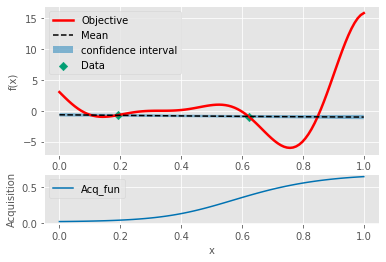

In [18]:
bo.plot()

### Take one step 

Assuming you have completed the optimisation part correctly 

Iter: 3, X_best=1.0, Objective=15.829731945974109


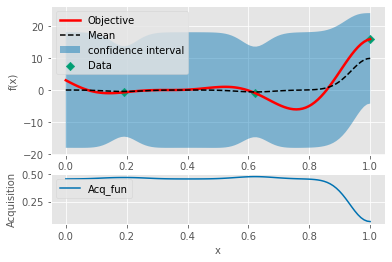

In [19]:
bo.optimise(n_iter=1, plot=True, verbose=True)

### Take couple more steps

Iter: 6, X_best=0.6464646464646465, Objective=-2.0394069022135892


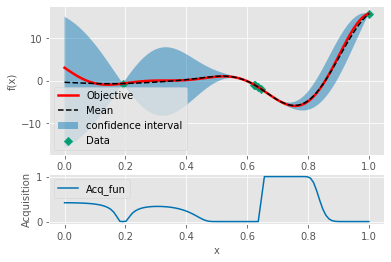

Iter: 7, X_best=0.6565656565656566, Objective=-2.5283642265838933


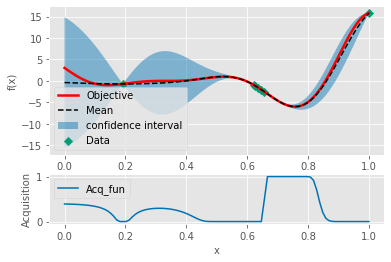

In [21]:
bo.optimise(n_iter=2, plot=True, verbose=True)

## More Acquisition Functions


### Expected Improvement (EI)

We have already implemented $\gamma(x)$ for PI and also implemented grid search maximsaisation for acquisition functions, in the following we reuse those methos by subclassing our Aquistion base class similar to PI

Expected Improvement:
    $$\alpha_{\text{EI}}(x) =  \sigma(x) \left( \gamma(x)\mathbf{\Phi}(x) + \mathcal{N}(\gamma(x) | 0, 1) \right)$$

In [ ]:
from scipy.stats import norm
class ExpectedImprovement(AquisitionBase):
    
    def __call__(self, model, x):
        assert isinstance(model, GPy.Model)
        
        mean_x = None # Edit This line       
        sigma_x = None # Edit This line
        
        y_best = np.min(model.Y)
        
        gamma_x = self.gamma(y_best, mean_x, sigma_x)
        EI = 0.0 # Edit This line
        return EI

### Lower Confidence Bound (LCB)

GP LCB :
$$\alpha_{\text{LCB}}(x) = - \left( \mu(x) - \kappa \, \sigma(x)\right), \qquad \kappa > 0 $$

In [ ]:
class LowerConfidenceBound(AquisitionBase):
    
    def __init__(self, kappa=2.56):
        super(LowerConfidenceBound, self).__init__()
        self.kappa = kappa
        
    def __call__(self, model, x):
        assert isinstance(model, GPy.Model)
        mean_x = None # Edit This line       
        sigma_x = None # Edit This line
        LCB = 0.0 # Edit This line
        return LCB

## Experiment with Different Acquisition Functions

With EI 

In [ ]:
obj = Objective.forrester()
acq_ei = ExpectedImprovement()
bo_ei = BayesianOptmisation(obj, aquisition_function=acq_ei, init_steps=2)
bo_ei.plot()

In [ ]:
bo_ei.optimise(n_iter=3, plot=True, verbose=True)

With LCB

In [ ]:
obj = Objective.forrester()
acq_lcb = LowerConfidenceBound()
bo_lcb = BayesianOptmisation(obj, aquisition_function=acq_lcb, init_steps=2)
bo_lcb.plot()

In [ ]:
bo_lcb.optimise(n_iter=3, plot=True, verbose=True)

## Exploration vs Exploitation 

Next we investigate role of slack variable in PI and EI and $\kappa$ in LCB for exploration

Forrester function we tried before doesn't have nearby local minimas where optimisation may get stuck. 
We create a custom cost function with many local minima that are close to true global minimum

In [ ]:
obj_hump = Objective.humps()
obj_hump.noise_std=0.01
a, b = obj_hump.limits
x_t = np.linspace(a, b, num=100)
plt.plot(x_t, obj_hump(x_t))

In [ ]:
obj = Objective.humps()
acq_ei = ExpectedImprovement()
bo_ei = BayesianOptmisation(obj, aquisition_function=acq_ei, init_steps=2)
bo_ei.plot()

In [ ]:
bo_ei.optimise(n_iter=10, plot=False)
bo_ei.plot()

In [ ]:
obj = Objective.humps()
acq_ei_slack = ExpectedImprovement(Xi=0.1)
bo_ei_slack = BayesianOptmisation(obj, aquisition_function=acq_ei_slack, init_steps=2)
bo_ei_slack.plot()

In [ ]:
bo_ei_slack.optimise(n_iter=10)
bo_ei_slack.plot()

## More experiments!!

Now run the same experiment, i.e., humps() objective with PI acquisition and LCB [$\kappa=[0.1, 2.5]$] 

effect of slack variables is more pronounced on PI acquisition, try different values of slack to see it for yourself.

## Even More experiments!!!

Up until now we used Squared exponential Kernel for GP models but we can use different kernels (or their combination) to make better priors depending on the thype of function 

In [ ]:
obj = Objective.humps()
acq_ei = ExpectedImprovement()
kernel = GPy.kern.Matern52(1)
bo_ei_mattern = BayesianOptmisation(obj, aquisition_function=acq_ei, init_steps=2, kernel=kernel)
bo_ei_mattern.plot()

In [ ]:
bo_ei_mattern.optimise(n_iter=30)
bo_ei_mattern.plot()